In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from keras_unet.metrics import iou, iou_thresholded, dice_coef

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
os.chdir('..')

In [3]:
from model.metric_utils import calculate_iou_df,  calculate_iou 
from model.loss_functions import jaccard_distance_loss, focal_loss, dice_coef_loss, binary_focal_loss

# Tune threshold for a scpecific model checkpoint

In [4]:
holdout_df_pkl_path_dir = os.path.join('preprocessed_dataframes', 'holdout_fold_0_df_cancer_info.pkl')

model_path = './best_performing_model/model_sampling.17-0.09.h5'
model_resize_dims = (128, 128)
loss_fn = binary_focal_loss(gamma=2., alpha=0.7)
prediction_batch_size = 32
pixel_threshold = 0.0875

Load `holdout_df` for `fold_0` (This assumes you have already executed the `main.py --mode train`)

In [18]:
holdout_fold_0_df = pd.read_pickle(holdout_df_pkl_path_dir)

holdout_fold_0_df.head()

x_tr_img_path  depth  \
index depth_i                                                             
001   0        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      1        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      2        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      3        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   
      4        ml4h_proj1_colon_cancer_ct\imagesTr\colon_001....     60   

                                                   y_tr_img_path  \
index depth_i                                                      
001   0        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   
      1        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   
      2        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   
      3        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   
      4        ml4h_proj1_colon_cancer_ct\labelsTr\colon_001....   

               cancer_pixel_area  has_cancer_pixels  
index depth_i                                        
001   0                      0.0              False  
      1                      0.0              False  
      2                      0.0              False  
      3                      0.0              False  
      4                      0.0              False

Load model

In [7]:
model = model = tf.keras.models.load_model(
    model_path,
    custom_objects={'iou':iou, 'iou_thresholded': iou_thresholded,
                    'binary_focal_loss_fixed': loss_fn})

In [8]:
iou_df, y_list, y_pred_list = calculate_iou_df(df_=holdout_fold_0_df, img_dims=model_resize_dims,
                                               model_=model, pixel_threshold=pixel_threshold,
                                               prediction_batch_size=prediction_batch_size)

In [9]:
iou_df

,iou
index,
001,0.000000
008,0.014979
009,0.000000
015,0.000000
050,0.109385
096,0.000000
115,0.000198
126,0.018269
141,0.000000


In [10]:
iou_df.iou.mean()

0.016050000706552655

Check mins and max of the predicted pixels to set the ranges when looking for a good threshold

In [11]:
for y_i, y_pred_i in zip(y_list, y_pred_list):
  print(np.min(y_pred_i))

0.024295947
0.022170266
0.024316907
0.027923748
0.02572728
0.023608748
0.02272472
0.024095915
0.027042862
0.023235222


In [12]:
for y_i, y_pred_i in zip(y_list, y_pred_list):
  print(np.max(y_pred_i))

0.18731242
0.21498904
0.22245656
0.12731746
0.18486786
0.2647509
0.15172875
0.30670488
0.23900378
0.23258016


<AxesSubplot:ylabel='Frequency'>

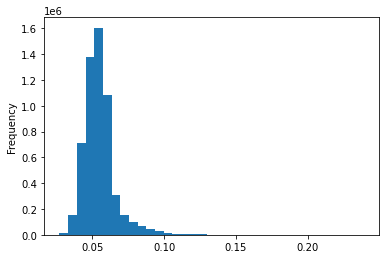

In [13]:
# This is very similar to what the train script saves, except that it does it for 5 images sampled at random
pd.Series(np.unique(y_pred_list[8])).plot.hist(bins=35)

Look for thresholds that have a better IoU

In [14]:
iou_list = list()
min_theshold = 0
max_threshold = 0.1
n_samples = 20
true_label_threshold = 0.5
result_list = list()

for threshold in np.random.uniform(min_theshold, max_threshold, n_samples):
  for y_i, y_pred_i in zip(y_list, y_pred_list):
    img_i_iou = calculate_iou(target=(y_i > true_label_threshold)*1,
                              prediction=(y_pred_i > threshold)*1)
    iou_list.append(img_i_iou)  

  result_list.append({'threshold': threshold, 'mean_iou':np.mean(img_i_iou)})

In [15]:
results_df = pd.DataFrame(result_list)
results_df

,threshold,mean_iou
0,0.060020,0.003520
1,0.034662,0.000497
2,0.000504,0.000497
3,0.040879,0.000501
4,0.038922,0.000498
5,0.041767,0.000503
6,0.077292,0.012094
7,0.038823,0.000498
8,0.016102,0.000497
9,0.033071,0.000497


In [16]:
print('Best theshold')
results_df.threshold[results_df.mean_iou.idxmax()]

Best theshold


0.08166977625100674

In [17]:
print('IoU of the best theshold')
results_df.mean_iou.max()

IoU of the best theshold


0.014812076945567685